In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as func
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim

from models import VGG
from train import train1Epoch
from datasetCreator import ImageSubset
torch.cuda.empty_cache()

import os
import cv2

In [2]:
os.listdir('../../..')

['.config',
 'teams',
 '.keras',
 'private',
 '.cache',
 '.jupyter',
 '.bash_history',
 '.python_history',
 '.nv',
 '.local',
 '.ipython',
 'public',
 '.conda']

In [3]:
with open('../../../teams/dsc-180a---a14-[88137]/example.txt') as f:
    lines = f.readlines()

In [4]:
lines

['hey this is Yash\n']

In [5]:
test_csv = pd.read_csv('data/BNPP_DT_test_with_ages.csv')
valid_csv = pd.read_csv('data/BNPP_DT_val_with_ages.csv')
train_csv = pd.read_csv('data/BNPP_DT_train_with_ages.csv')
h5py = h5py.File('data/bnpp_frontalonly_1024_10.hdf5')
train_csv

,unique_key,bnpp_value_log,BNPP_weight,PNA_mask,PNA_wight_mask,BNP_value,age_at_sampletime
0,Flodure_51396672_img1,0.690196,1,None,1,4.9,45
1,Okepik_50995691_img1,0.690196,1,None,1,4.9,53
2,Kuesluco_51713925_img1,0.690196,1,None,1,4.9,54
3,Gumepra_51602745_img1,0.690196,1,None,1,4.9,58
4,Gapeklik_51060218_img1,0.690196,1,None,1,4.9,19
...,...,...,...,...,...,...,...
21369,Puesrueci_53095611_img1,4.845099,1,None,1,70000.1,57
21370,Adakas_52269723_img1,4.845099,1,None,1,70000.1,73
21371,Ekugud_52967627_img1,4.845099,1,None,1,70000.1,53
21372,Beguchouf_52038583_img1,4.845099,1,None,1,70000.1,60


In [6]:
train = train_csv[['unique_key','bnpp_value_log']]
train

,unique_key,bnpp_value_log
0,Flodure_51396672_img1,0.690196
1,Okepik_50995691_img1,0.690196
2,Kuesluco_51713925_img1,0.690196
3,Gumepra_51602745_img1,0.690196
4,Gapeklik_51060218_img1,0.690196
...,...,...
21369,Puesrueci_53095611_img1,4.845099
21370,Adakas_52269723_img1,4.845099
21371,Ekugud_52967627_img1,4.845099
21372,Beguchouf_52038583_img1,4.845099


#list(h5py.keys())
data = {}
ind=0
for key in list(h5py.keys()):
    image = Image.fromarray(f[key][:])
    #resizing to 224 x 224
    #formatted = (image * 255 / np.max(image)).astype('uint8')
    #img = Image.fromarray(formatted).resize((224,224))
    
    data[ind]=[key,image]
    #img_tensor = transform(img)
    #data[key] = img_tensor
    #img.save(f'data/images/{key}.jpg')

    ind+=1
data=pd.DataFrame(data).T
data.columns = ['patientID','image']
merged = data.merge(train, how='inner',left_on='patientID',right_on='unique_key')
merged

transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
train_data = ImageSubset(csv_file = 'data/BNPP_DT_train_with_ages.csv', data=data, img_dir='data/images/')
train_data

In [7]:
batch_size = 8 #maybe change to 16, 8

# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5), std=(0.5))
#     ])

train_set = ImageSubset(csv_file = train_csv, h5py_file = h5py) #, transform = train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)

# valid_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5), std=(0.5))
#     ])

valid_set = ImageSubset(csv_file = valid_csv, h5py_file = h5py) #, transform = valid_transform)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

#print(train[0])
#print(iter(train_loader).next())
#print(train.__getitem__(0))

#example from Pytorch Website
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, num_workers=2)

#print(iter(training_loader).next(), training_loader)
#print(training_set.__getitem__(0))

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = VGG('VGG16').to(device)
model

cuda


VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [9]:
x = torch.randn(1, 1, 224, 224)
#print(x, len(x))
x = x.to(device)
out = model(x)
#print(out, out.shape)

3.75  1.53  1.89  3.54  0.69  2.94  3.60  2.38


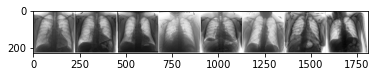

In [10]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(str('%.2f' % labels[j].item()) for j in range(batch_size)))

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")
epochs = 10 #40-50 epochs

total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function, Mean Absolute Error
loss_fn = nn.MSELoss() #nn.L1Loss()

# the optimizer
# need to tune optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)

[INFO]: Computation device: cuda
[INFO]: 134,271,937 total parameters.
[INFO]: 134,271,937 trainable parameters.


# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        #print(data)

        image, bnpp = data
        image, bnpp = image.to(device), bnpp.to(device)
        print(image,bnpp)
        #print(i)
        #print(data)
        #print(data[0])
        #print(data[1])
        #print(data[2])
        #break
        image = image.to(device)
        bnpp = bnpp.to(device)

        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        #outputs = model(image.float())
        # calculate the loss
        loss = loss_fn(outputs, bnpp)
        train_running_loss += loss.item()
        # calculate the accuracy
        #_, preds = torch.max(outputs.data, 1)
        #train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()

    epoch_loss = train_running_loss / counter
    #epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss

In [12]:

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train1Epoch(epoch_number, model, optimizer, loss_fn, train_loader, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs.squeeze(), vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    #writer.add_figure(tag='Train Loss',
    #                figure=plt.scatter(epoch,avg_loss))
    #writer.add_figure(tag='Validation Loss',
    #                figure=plt.scatter(epoch,avg_vloss))
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


  1%|▏         | 1/71 [00:00<00:11,  5.86it/s]

tensor(9.4471, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 2/71 [00:00<00:09,  7.53it/s]

tensor(20.5142, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3.0360, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(14.4992, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▌         | 4/71 [00:00<00:07,  9.10it/s]

tensor(4.2298, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 6/71 [00:00<00:06,  9.68it/s]

tensor(0.5957, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.1729, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 7/71 [00:00<00:06,  9.76it/s]

tensor(4.8051, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 9/71 [00:00<00:06, 10.01it/s]

tensor(3.1463, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▍        | 10/71 [00:01<00:06,  9.51it/s]

tensor(1.9069, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 11/71 [00:01<00:06,  9.62it/s]

tensor(3.3973, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3.4273, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 13/71 [00:01<00:06,  8.84it/s]

tensor(2.4589, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.0049, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 15/71 [00:01<00:05,  9.38it/s]

tensor(1.8603, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3.2712, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9722, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▌       | 18/71 [00:01<00:05,  9.58it/s]

tensor(1.8169, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9526, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.8124, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 21/71 [00:02<00:05,  9.62it/s]

tensor(0.3121, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3290, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 23/71 [00:02<00:04,  9.87it/s]

tensor(1.2637, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.0415, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.6135, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 27/71 [00:02<00:04,  9.98it/s]

tensor(1.6966, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6140, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0935, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 30/71 [00:03<00:04, 10.14it/s]

tensor(0.8753, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.2910, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3399, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▋     | 33/71 [00:03<00:03,  9.61it/s]

tensor(2.2404, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.7664, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 35/71 [00:03<00:03,  9.48it/s]

tensor(2.2308, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6952, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 37/71 [00:03<00:03,  9.63it/s]

tensor(1.4249, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0702, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1188, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▋    | 40/71 [00:04<00:03,  9.82it/s]

tensor(2.8037, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4322, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 42/71 [00:04<00:03,  9.38it/s]

tensor(2.5397, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1607, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 44/71 [00:04<00:03,  8.80it/s]

tensor(1.0222, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9299, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▍   | 46/71 [00:04<00:02,  9.09it/s]

tensor(2.3281, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1585, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 48/71 [00:05<00:02,  9.20it/s]

tensor(2.7942, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5172, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|███████   | 50/71 [00:05<00:02,  9.26it/s]

tensor(1.6981, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.8093, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 52/71 [00:05<00:02,  8.80it/s]

tensor(2.0846, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.8631, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 54/71 [00:05<00:01,  8.80it/s]

tensor(0.6577, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.6131, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 56/71 [00:05<00:01,  8.98it/s]

tensor(1.2105, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.7197, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 58/71 [00:06<00:01,  9.12it/s]

tensor(2.4445, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9353, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▍ | 60/71 [00:06<00:01,  9.21it/s]

tensor(0.6870, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.5147, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 62/71 [00:06<00:01,  8.71it/s]

tensor(2.6412, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4697, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 64/71 [00:06<00:00,  9.01it/s]

tensor(2.4615, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1907, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 66/71 [00:07<00:00,  9.11it/s]

tensor(1.3074, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1727, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▌| 68/71 [00:07<00:00,  9.09it/s]

tensor(2.6095, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0422, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 71/71 [00:07<00:00,  9.36it/s]


tensor(1.1151, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.2874, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.9819, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 8/10 [00:01<00:00,  7.11it/s]


RuntimeError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 10.76 GiB total capacity; 9.72 GiB already allocated; 7.44 MiB free; 9.77 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# save the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            }, '../outputs/VGG16Reg.pth')
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, color='green', linestyle='-', 
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-', 
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../outputs/accuracy.jpg')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss'
)
plt.plot(
    valid_loss, color='red', linestyle='-', 
    label='validataion loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../outputs/loss.jpg')
plt.show()
 
print('TRAINING COMPLETE')

#to load saved model
saved_model = VGG()
saved_model.load_state_dict(torch.load(PATH))